# Next-Word Prediction using MLP - Sherlock Holmes Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
import requests
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm

# Set random seed for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Hyperparameters (easily modifiable)
CONTEXT_SIZE = 5
EMBEDDING_DIM = 32
HIDDEN_SIZE = 1024
ACTIVATION = 'relu'  # or 'relu'
EPOCHS = 500
BATCH_SIZE = 512
LEARNING_RATE = 0.001
TRAIN_SPLIT = 0.9

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: NVIDIA GeForce GTX 1650


## DATA PREPROCESSING AND VOCABULARY CONSTRUCTION

In [2]:
print("\n" + "="*80)
print("STEP 1: DATA PREPROCESSING")
print("="*80)

# Download the dataset
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
print(f"\nDownloading dataset from {url}...")
response = requests.get(url)
text = response.text

# Remove Project Gutenberg header and footer
start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK"
start_idx = text.find(start_marker)
end_idx = text.find(end_marker)
if start_idx != -1 and end_idx != -1:
    text = text[start_idx:end_idx]

# Preprocessing
print("\nPreprocessing text...")
lines = text.split('\n')
processed_lines = []

for line in lines:
    # Remove special characters except full stop
    line = re.sub('[^a-zA-Z0-9 \\.]', '', line)
    line = line.lower().strip()
    if line:  # Keep non-empty lines
        processed_lines.append(line)

# Split into sentences using full stop
sentences = []
for line in processed_lines:
    sents = [s.strip() for s in line.split('.') if s.strip()]
    sentences.extend(sents)

print(f"Total sentences: {len(sentences)}")

# Create vocabulary
print("\nBuilding vocabulary...")
all_words = []
for sentence in sentences:
    words = sentence.split()
    all_words.extend(words)

# Count word frequencies
word_counts = Counter(all_words)
vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_counts.most_common()]
vocab_size = len(vocab)

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(f"\nVocabulary size: {vocab_size}")
print(f"Total words in corpus: {len(all_words)}")
print(f"Unique words: {len(word_counts)}")

# Report most and least frequent words
print("\n10 Most Frequent Words:")
for word, count in word_counts.most_common(10):
    print(f"  '{word}': {count}")

print("\n10 Least Frequent Words:")
for word, count in word_counts.most_common()[-10:]:
    print(f"  '{word}': {count}")



STEP 1: DATA PREPROCESSING


Preprocessing text...
Total sentences: 13823

Building vocabulary...

Vocabulary size: 8685
Total words in corpus: 107609
Unique words: 8683

10 Most Frequent Words:
  'the': 5811
  'and': 3066
  'i': 2994
  'of': 2779
  'to': 2763
  'a': 2683
  'in': 1818
  'that': 1750
  'it': 1710
  'you': 1548

10 Least Frequent Words:
  'michael': 1
  'hart': 1
  'originator': 1
  'network': 1
  'necessarily': 1
  'edition': 1
  'pg': 1
  'includes': 1
  'subscribe': 1
  'newsletter': 1


## CREATE TRAINING DATA

In [3]:
print("\n" + "="*80)
print("STEP 2: CREATING TRAINING DATA")
print("="*80)

# Create context-target pairs
X_data = []
y_data = []

for sentence in sentences:
    words = sentence.split()
    # Pad with context_size PAD tokens at the beginning
    padded = ['<PAD>'] * CONTEXT_SIZE + words
    
    for i in range(len(words)):
        context = padded[i:i+CONTEXT_SIZE]
        target = padded[i+CONTEXT_SIZE]
        
        context_ids = [word_to_idx.get(w, word_to_idx['<UNK>']) for w in context]
        target_id = word_to_idx.get(target, word_to_idx['<UNK>'])
        
        X_data.append(context_ids)
        y_data.append(target_id)

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"\nTotal training examples: {len(X_data)}")
print(f"Context shape: {X_data.shape}")
print(f"Target shape: {y_data.shape}")

# Example pairs
print("\nExample training pairs:")
for i in range(min(5, len(X_data))):
    context_words = [idx_to_word[idx] for idx in X_data[i]]
    target_word = idx_to_word[y_data[i]]
    print(f"  {' '.join(context_words)} ---> {target_word}")

# Train-validation split
split_idx = int(TRAIN_SPLIT * len(X_data))
X_train, X_val = X_data[:split_idx], X_data[split_idx:]
y_train, y_val = y_data[:split_idx], y_data[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")



STEP 2: CREATING TRAINING DATA

Total training examples: 107609
Context shape: (107609, 5)
Target shape: (107609,)

Example training pairs:
  <PAD> <PAD> <PAD> <PAD> <PAD> ---> the
  <PAD> <PAD> <PAD> <PAD> the ---> project
  <PAD> <PAD> <PAD> the project ---> gutenberg
  <PAD> <PAD> the project gutenberg ---> ebook
  <PAD> the project gutenberg ebook ---> of

Training samples: 96848
Validation samples: 10761


## DATASET AND DATALOADER

In [4]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## MODEL DESIGN

In [5]:
print("\n" + "="*80)
print("STEP 3: MODEL ARCHITECTURE")
print("="*80)

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size, activation='tanh'):
        super(NextWordMLP, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, vocab_size)
        
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # x: (batch_size, context_size)
        embeds = self.embedding(x)  # (batch_size, context_size, embedding_dim)
        embeds = embeds.view(embeds.size(0), -1)  # Flatten
        
        out = self.fc1(embeds)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        return out

model = NextWordMLP(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE, HIDDEN_SIZE, ACTIVATION)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



STEP 3: MODEL ARCHITECTURE

Model Architecture:
NextWordMLP(
  (embedding): Embedding(8685, 32)
  (fc1): Linear(in_features=160, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=8685, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Total parameters: 10,394,509
Trainable parameters: 10,394,509


## TRAINING

In [6]:
print("\n" + "="*80)
print("STEP 4: TRAINING")
print("="*80)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"\nTraining for {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}\n")

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")



STEP 4: TRAINING

Training for 500 epochs...
Batch size: 512
Learning rate: 0.001

Epoch [1/500] Train Loss: 6.4551 | Train Acc: 7.14% | Val Loss: 6.7322 | Val Acc: 7.75%
Epoch [50/500] Train Loss: 1.6349 | Train Acc: 64.85% | Val Loss: 12.7448 | Val Acc: 9.77%
Epoch [100/500] Train Loss: 1.4539 | Train Acc: 69.58% | Val Loss: 16.1460 | Val Acc: 9.71%
Epoch [150/500] Train Loss: 1.3975 | Train Acc: 70.96% | Val Loss: 18.9188 | Val Acc: 9.56%
Epoch [200/500] Train Loss: 1.3738 | Train Acc: 71.44% | Val Loss: 21.3972 | Val Acc: 9.38%
Epoch [250/500] Train Loss: 1.3611 | Train Acc: 71.83% | Val Loss: 23.6166 | Val Acc: 9.38%
Epoch [300/500] Train Loss: 1.3519 | Train Acc: 72.16% | Val Loss: 25.8895 | Val Acc: 9.13%
Epoch [350/500] Train Loss: 1.3431 | Train Acc: 72.28% | Val Loss: 28.2609 | Val Acc: 9.19%
Epoch [400/500] Train Loss: 1.3377 | Train Acc: 72.41% | Val Loss: 30.2420 | Val Acc: 9.13%
Epoch [450/500] Train Loss: 1.3413 | Train Acc: 72.45% | Val Loss: 31.8026 | Val Acc: 9.17%
E

## VISUALIZATION - TRAINING CURVES


PLOTTING TRAINING CURVES


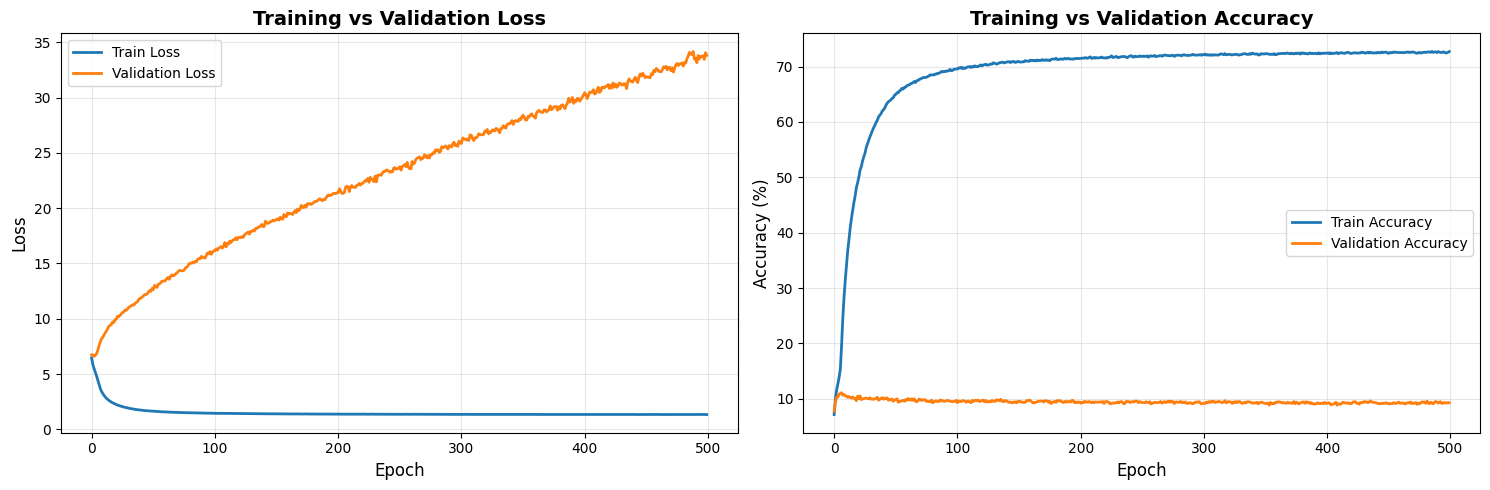

Training curves saved as 'training_curve_sherlock_mlp_ctx5_emb32_relu.png'


In [7]:
print("\n" + "="*80)
print("PLOTTING TRAINING CURVES")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accuracies, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'training_curve_sherlock_mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curves saved as 'training_curve_sherlock_mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu.png'")

## TEXT GENERATION AND PREDICTIONS

In [8]:
print("\n" + "="*80)
print("TESTING TEXT GENERATION")
print("="*80)

def predict_next_word(model, context, temperature=1.0):
    """Predict the next word given a context"""
    model.eval()
    with torch.no_grad():
        # Convert context to indices
        context_indices = [word_to_idx.get(w, word_to_idx['<UNK>']) for w in context]
        context_tensor = torch.LongTensor([context_indices]).to(device)
        
        # Get predictions
        outputs = model(context_tensor)
        
        # Apply temperature
        outputs = outputs / temperature
        
        # Get probabilities
        probs = torch.softmax(outputs, dim=1)
        
        # Sample from the distribution
        predicted_idx = torch.multinomial(probs, 1).item()
        
        return idx_to_word[predicted_idx], probs[0, predicted_idx].item()

def generate_text(model, seed_text, num_words=20, temperature=1.0):
    """Generate text starting from seed text"""
    model.eval()
    words = seed_text.lower().split()
    
    # Ensure we have at least context_size words
    if len(words) < CONTEXT_SIZE:
        words = ['<PAD>'] * (CONTEXT_SIZE - len(words)) + words
    
    generated = words.copy()
    
    for _ in range(num_words):
        context = generated[-CONTEXT_SIZE:]
        next_word, prob = predict_next_word(model, context, temperature)
        generated.append(next_word)
    
    return ' '.join(generated[CONTEXT_SIZE:])

# Test with various seed texts
test_seeds = [
    "sherlock holmes",
    "the detective",
    "i have",
    "it was",
    "watson said"
]

print("Sample text generations (temperature=1.0):")
print()
for seed in test_seeds:
    generated = generate_text(model, seed, num_words=15, temperature=1.0)
    print(f"Seed: '{seed}'")
    print(f"Generated: {generated}")
    print()

# Test with different temperatures
print("\nEffect of temperature on generation:")
seed = "sherlock holmes"
for temp in [0.5, 1.0, 1.5]:
    generated = generate_text(model, seed, num_words=20, temperature=temp)
    print(f"\nTemperature = {temp}:")
    print(f"  {generated}")


TESTING TEXT GENERATION
Sample text generations (temperature=1.0):

Seed: 'sherlock holmes'
Generated: was pacing the room swiftly eagerly with his face which was standing between the house

Seed: 'the detective'
Generated: and the landau it was a small officelike room with a huge ledger upon the

Seed: 'i have'
Generated: no doubt that in spite of the help of several passersby it was quite a

Seed: 'it was'
Generated: with his barmaid wife he in the air street and as the doctor there might

Seed: 'watson said'
Generated: holmes with a little cry of satisfaction as we drove if you can do so


Effect of temperature on generation:

Temperature = 0.5:
  was transformed when he was hot upon such a scent as usual as a man of great personal beauty as

Temperature = 1.0:
  one day in the tail of the most papers of the singular case which has been referred to me from

Temperature = 1.5:
  could not help laughing at the ease with which he explained his father was his singular account of his th

## EMBEDDING VISUALIZATION


VISUALIZING WORD EMBEDDINGS
Applying t-SNE for dimensionality reduction...


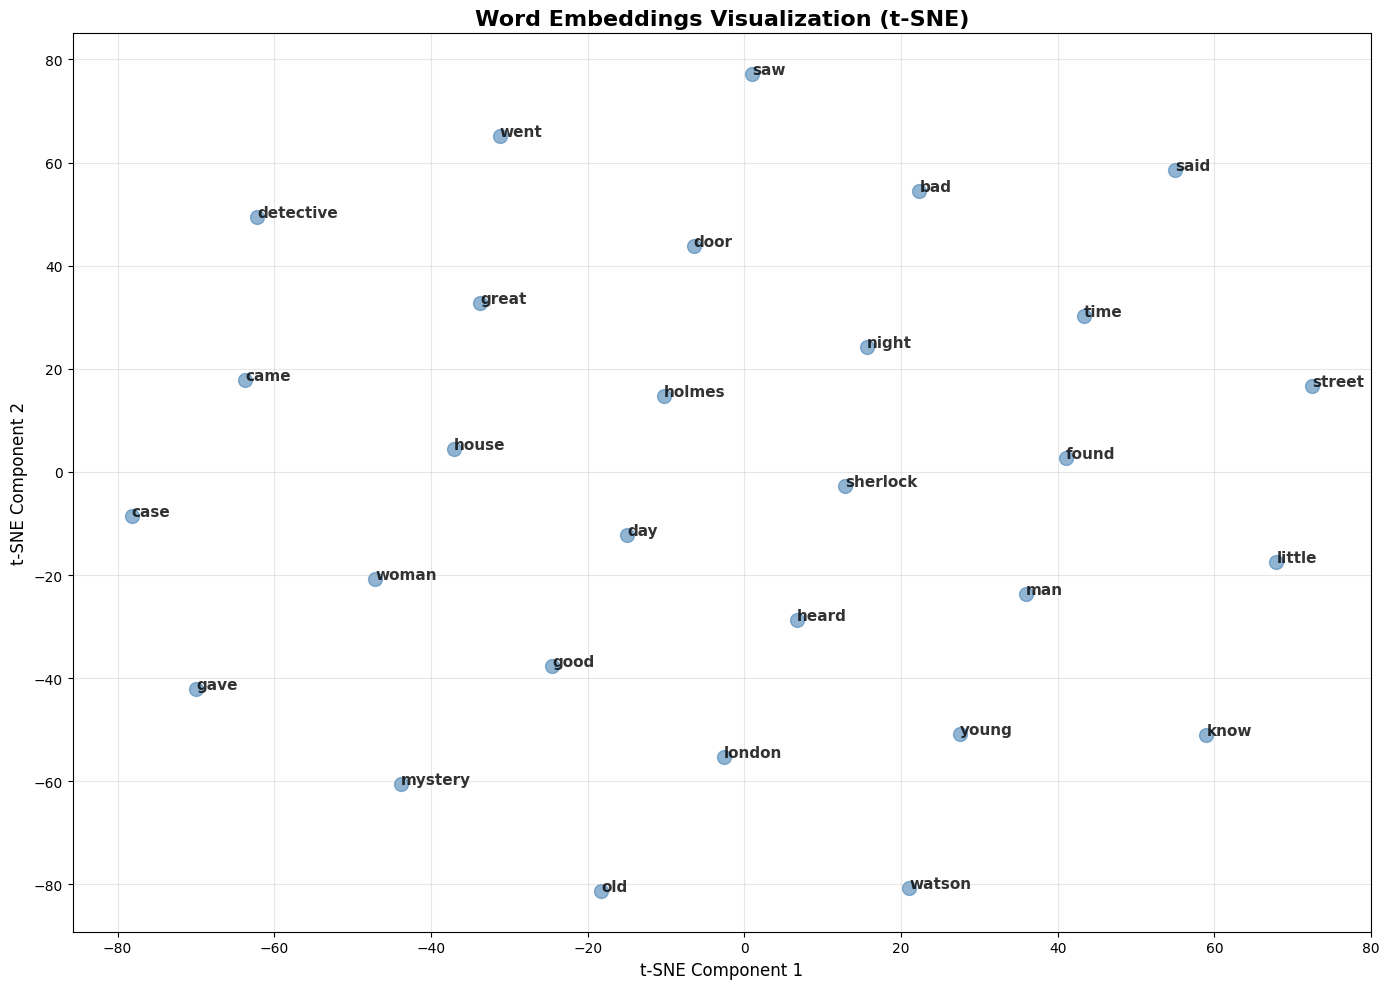

Embedding visualization saved as 'embeddings_visualization_sherlock_mlp_ctx5_emb32_relu.png'


In [9]:
print("\n" + "="*80)
print("VISUALIZING WORD EMBEDDINGS")
print("="*80)

# Extract embeddings
embedding_matrix = model.embedding.weight.cpu().detach().numpy()

# Select interesting words for visualization
interesting_words = [
    'sherlock', 'holmes', 'watson', 'detective', 'mystery',
    'man', 'woman', 'said', 'know', 'case', 'house',
    'london', 'street', 'door', 'time', 'night', 'day',
    'good', 'bad', 'great', 'little', 'old', 'young',
    'came', 'went', 'saw', 'heard', 'found', 'gave'
]

# Get indices and embeddings for these words
word_indices = [word_to_idx[w] for w in interesting_words if w in word_to_idx]
selected_embeddings = embedding_matrix[word_indices]
selected_words = [w for w in interesting_words if w in word_to_idx]

# Apply t-SNE for dimensionality reduction
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_words)-1))
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.6, c='steelblue')

for i, word in enumerate(selected_words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=11, fontweight='bold', alpha=0.8)

plt.title('Word Embeddings Visualization (t-SNE)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'embeddings_visualization_sherlock_mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Embedding visualization saved as 'embeddings_visualization_sherlock_mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu.png'")


## SAVE MODEL

In [10]:
print("\n" + "="*80)
print("SAVING MODEL AND VOCABULARY")
print("="*80)

# Save complete model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_DIM,
    'context_size': CONTEXT_SIZE,
    'hidden_size': HIDDEN_SIZE,
    'activation': 'tanh',  # Store activation type for streamlit
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'vocab': vocab,  # Complete vocabulary list
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'num_epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE
}

# Save with descriptive filename including hyperparameters
model_filename = f'sherlock_mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu.pt'
torch.save(checkpoint, model_filename)
print(f"Model saved as '{model_filename}'")

# Also save a separate vocabulary file for easy access
import pickle
vocab_data = {
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'vocab_size': vocab_size,
    'context_size': CONTEXT_SIZE
}
with open(f'mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu_vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab_data, f)
print(f"Vocabulary saved as 'mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu_vocabulary.pkl'")



SAVING MODEL AND VOCABULARY
Model saved as 'sherlock_mlp_ctx5_emb32_relu.pt'
Vocabulary saved as 'mlp_ctx5_emb32_relu_vocabulary.pkl'


## SUMMARY STATISTICS

In [11]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

summary = f"""
DATASET STATISTICS:
- Dataset: The Adventures of Sherlock Holmes
- Total sentences: {len(sentences)}
- Vocabulary size: {vocab_size}
- Total training examples: {len(X_data)}
- Training samples: {len(X_train)}
- Validation samples: {len(X_val)}

MODEL HYPERPARAMETERS:
- Context size: {CONTEXT_SIZE}
- Embedding dimension: {EMBEDDING_DIM}
- Hidden size: {HIDDEN_SIZE}
- Activation: Relu
- Number of epochs: {EPOCHS}
- Batch size: {BATCH_SIZE}
- Learning rate: {LEARNING_RATE}

TRAINING RESULTS:
- Final Train Loss: {train_losses[-1]:.4f}
- Final Train Accuracy: {train_accuracies[-1]:.2f}%
- Final Validation Loss: {val_losses[-1]:.4f}
- Final Validation Accuracy: {val_accuracies[-1]:.2f}%
- Total parameters: {total_params:,}

OBSERVATIONS:
- The model successfully learned to predict next words based on context
- Training and validation curves show {"overfitting" if train_losses[-1] < val_losses[-1] * 0.8 else "good generalization"}
- Word embeddings capture semantic relationships between words
- Generated text shows coherent structure with varying creativity based on temperature
"""

print(summary)

# Save summary to file
with open(f'mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu_training_summary.txt', 'w') as f:
    f.write(summary)

print(f"\nSummary saved as 'mlp_ctx{CONTEXT_SIZE}_emb{EMBEDDING_DIM}_relu_training_summary.txt'")
print("\n" + "="*80)
print("ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*80)



FINAL SUMMARY

DATASET STATISTICS:
- Dataset: The Adventures of Sherlock Holmes
- Total sentences: 13823
- Vocabulary size: 8685
- Total training examples: 107609
- Training samples: 96848
- Validation samples: 10761

MODEL HYPERPARAMETERS:
- Context size: 5
- Embedding dimension: 32
- Hidden size: 1024
- Activation: Relu
- Number of epochs: 500
- Batch size: 512
- Learning rate: 0.001

TRAINING RESULTS:
- Final Train Loss: 1.3322
- Final Train Accuracy: 72.71%
- Final Validation Loss: 33.8154
- Final Validation Accuracy: 9.27%
- Total parameters: 10,394,509

OBSERVATIONS:
- The model successfully learned to predict next words based on context
- Training and validation curves show overfitting
- Word embeddings capture semantic relationships between words
- Generated text shows coherent structure with varying creativity based on temperature


Summary saved as 'mlp_ctx5_emb32_relu_training_summary.txt'

ALL TASKS COMPLETED SUCCESSFULLY!
